In [3]:
# Fixed costs and exit gain for conventional producers
# reduced entry costs for renewable producers
import numpy as np
from scipy.stats import norm
from scipy.optimize import linprog
import matplotlib
import matplotlib.pyplot as plt
import time
from cvxopt import solvers, matrix, sparse
from scipy.optimize import root_scalar
from scipy.sparse import bsr_matrix
from scipy.stats import gamma
from scipy.stats import beta

In [6]:
# interval
Smin=.1
Smax=.7
Cmin=0
Cmax = 120
tmin=0
tmax=30

# number for points
NS=21
NC = 21
Nt=61

# discretization
dS=1.*(Smax-Smin)/(NS-1)
dC = 1.*(Cmax-Cmin)/(NC-1)
dt=1.*(tmax-tmin)/(Nt-1)

# define grid in space
S = np.linspace(Smin,Smax,NS)
C = np.linspace(Cmin,Cmax,NC)
T = np.linspace(tmin,tmax,Nt)

# long-term average cost
theta_G = 37.94
theta_C = 34
theta_R = 0.4

# standard deviation
std_G = 12.53
std_C = 10
std_R = 0.075

# rate of mean reversion
kG=0.5
kC=0.5
kR = 0.5

# variability of the cost process 
delta_G = std_G*np.sqrt(2.*kG/theta_G)
delta_C = std_C*np.sqrt(2.*kC/theta_C)
delta_R = std_R*np.sqrt(2.*kR/(theta_R*(1-theta_R)-std_R*std_R))

rho=.08

epsilon = 0.5

# depreciation rate
gamma_G = np.log(2.)/15.
gamma_C = np.log(2.)/20.
gamma_R = np.log(2.)/12.5

# conversion of hourly revenue per MW into annual revenue per kW
convcoef = 24.*365.25/1000. 

# maximal price 
P=150.

K_R=1750. # per kW of installed capacity (who enter - fixing cost of owning the plant)
K_G_enter = 1450 # per kW of installed capacity (who enter - fixing cost of owning the plant)
K_G = 0 # per kW of installed capacity (who exit - value recovered if the plant is sold)
K_C = 0 # per kW of installed capacity (who exit - value recovered if the plant is sold)

# fixed cost
k_G = 42. # per kW per year
k_C = 68. # per kW per year
k_R = 30. # per kW per year


# initial condition gas producers who exit
alpha_G = (theta_G/std_G)*(theta_G/std_G)
beta_G = theta_G/std_G/std_G
InitialOmega = 31.9*beta_G*gamma.pdf(beta_G*C,alpha_G)
# initial condition gas producers who enter
InitialLambda = 36.*beta_G*gamma.pdf(beta_G*C,alpha_G)
BarLambda = 67.9*beta_G*gamma.pdf(beta_G*C,alpha_G)

# initial condition coal producers who exit
alpha_C = (theta_C/std_C)*(theta_C/std_C)
beta_C = theta_C/std_C/std_C
InitialMu = 43.*beta_C*gamma.pdf(beta_C*C,alpha_C)

# initial condition renewable producers
alpha_R = theta_R*(theta_R*(1.-theta_R)/std_R/std_R-1.)
beta_R = (1.-theta_R)*(theta_R*(1.-theta_R)/std_R/std_R-1.)
BarEta=114.7*beta.pdf(S,alpha_R,beta_R)
InitialEta=60.*beta.pdf(S,alpha_R,beta_R)

# demand
demand = np.array([33.68,33.68,33.68,33.68,33.11,33.11,33.11,33.11,32.68,32.68,32.68,32.68,
                   32.45,32.45,32.45,32.45,32.53,32.53,32.53,32.53,32.81,32.81,32.81,32.81,
                   33.19,33.19,33.19,33.19,33.56,33.56,33.56,33.56,
                   34.03,34.03,34.03,34.03,34.64,34.64,34.64,34.64,35.34,35.34,35.34,35.34,
                   36.02,36.02,36.02,36.02,36.78,36.78,36.78,36.78,37.29,37.29,37.29,37.29,
                   37.78,37.78,37.78,37.78,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,
                  38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,
                  38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,
                  38.39,38.39,38.39,38.39,38.39,38.39,38.39])

# Adjusting for seasonal cycle
sc = np.array([1.10352635, 0.93209028, 0.90656527, 1.05781809])
for i in range(25): demand[i*4:(i+1)*4] = demand[i*4:(i+1)*4]*sc
demand[100] = demand[100]*sc[0]

# peak / offpeak demand ratio
Dc = 1.2875630406414182

# peak hours
pcoef = 65./168
# off-peak hours
opcoef = 1.-pcoef

# peak demand
pdemand = demand*Dc/(pcoef*Dc+opcoef)
# off-peak demand
opdemand = demand/(pcoef*Dc+opcoef)

# fonction G in the definition of the reward function for exit
def G(x):
    return (epsilon/2+(x-epsilon))*(x>epsilon)+x*x/2/epsilon*(x>0)*(x<=epsilon)

def F(x):
    return (x-epsilon>0)+x/epsilon*(x>0)*(x<=epsilon)

# baseline supply
def F0(X):
    return 35.2*X/150.

# fonction g - payoff exit gas player
def g(x,p,t):
    return convcoef*G(p-x)-k_G - (rho+gamma_G)*K_G*np.exp(-gamma_G*t)

# function h - payoff entry gas player
def h(x,p,t):
    return -convcoef*G(p-x) + k_G + rho*K_G_enter + gamma_G*K_G_enter*np.exp(-(rho+gamma_G)*(tmax-t))

# fonction f - payoff entry renewable player
def f(x,p,t):
    return -convcoef*p*x + k_R + rho*K_R + gamma_R*K_R*np.exp(-(rho+gamma_R)*(tmax-t))

# fonction l - payoff exit coal player
def l(x,p,t):
    return convcoef*G(p-x)-k_C - (rho+gamma_C)*K_C*np.exp(-gamma_C*t)

# residual demand
def computeR(eta,dem):
    R = np.zeros(Nt)
    maxdem = sum(S[:-1]*BarEta[0:NS-1])*dS
    for i in range(Nt):
        R[i]=dem[i]+sum(S[:-1]*eta[i*NS:(i+1)*NS-1])*dS-maxdem
        R[i] = R[i]*(R[i]>0)
    return R

# total supply by the conventional gas producers at prive level p
def computeM(l, p):
    M = np.zeros(Nt)
    maxdem = sum(F(p-C[:-1])*BarLambda[0:NC-1])*dC
    for i in range(Nt):
        M[i] = maxdem - sum(F(p-C[:-1])*l[i*NC:(i+1)*NC-1])*dC
    return M 

# function which computes the price for given densities at a given time t
def price(t,R,O,L,M):
    if R[t]==0: return 0
    def func(x):
        return sum(F(x-C)*(O[t*NC:(t+1)*NC]+M[t*NC:(t+1)*NC]))*dC-R[t]+F0(x)+computeM(L,x)[t]
    if func(P)<=0: return P
    return root_scalar(func,bracket=(0.,P),x0 = P/2).root  

################################################################################################################
# find the maximum on omega at a given iteration
################################################################################################################
def OptExit_G(Omega,Eta,Lambda,Mu):
    # residual demand for peak and off-peak demand
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    # price for peak and off-peak demand
    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Lambda,Mu)
        Prop[j] = price(j,Rop,Omega,Lambda,Mu)

    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*g(C,Prp[i],T[i])+opcoef*g(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_G*delta_G*C*dt/(dC*dC)
    V1 =-delta_G*delta_G*C[1:]*dt/(2*dC*dC)+kG*(theta_G-C[1:])*dt/(2*dC)
    V2=-delta_G*delta_G*C[:-1]*dt/(2*dC*dC)-kG*(theta_G-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialOmega


    
    t0 = time.time()
    res = linprog(-H[NC:],bsr_matrix(A_ub),b_ub,options={"sparse":True})
    if(res.status): print('OpExit: '+res.message)

    M1 = res.x
    val = np.dot(H[NC:],Omega[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on lambda at a given iteration
################################################################################################################
def OptEntry_G(Omega,Eta,Lambda,Mu):
    # residual demand for peak and off-peak demand
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    # price for peak and off-peak demand
    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Lambda,Mu)
        Prop[j] = price(j,Rop,Omega,Lambda,Mu)

    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*h(C,Prp[i],T[i])+opcoef*h(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_G*delta_G*C*dt/(dC*dC)
    V1 =-delta_G*delta_G*C[1:]*dt/(2*dC*dC)+kG*(theta_G-C[1:])*dt/(2*dC)
    V2=-delta_G*delta_G*C[:-1]*dt/(2*dC*dC)-kG*(theta_G-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialLambda


    
    t0 = time.time()
    res = linprog(-H[NC:],bsr_matrix(A_ub),b_ub,options={"sparse":True})
    if(res.status): print('OpExit: '+res.message)

    M1 = res.x
    val = np.dot(H[NC:],Lambda[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on eta at a given iteration
################################################################################################################
def OptEntry_R(Omega,Eta,Lambda,Mu):
    # residual demand for peak and off-peak demand
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    # price for peak and off-peak demand
    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Lambda,Mu)
        Prop[j] = price(j,Rop,Omega,Lambda,Mu)

    # constraints
    barH=np.zeros(Nt*NS)
    for i in range(Nt):
        barH[i*NS:(i+1)*NS]=dS*dt*np.exp(-rho*T[i])*(pcoef*f(S,Prp[i],T[i])+opcoef*f(S,Prop[i],T[i]))        
    # neumann conditions
    barA=np.zeros((NS,NS))
    barV=1.+delta_R*delta_R*S*(1-S)*dt/(dS*dS)
    barV1 = -delta_R*delta_R*S[1:]*(1.-S[1:])*dt/(2*dS*dS)+kR*(theta_R-S[1:])*dt/(2*dS)
    barV2 = -delta_R*delta_R*S[:-1]*(1.-S[:-1])*dt/(2*dS*dS)-kR*(theta_R-S[:-1])*dt/(2*dS)
    barA.flat[::NS+1] = barV
    barA.flat[1::NS+1] = barV1
    barA.flat[NS::NS+1] = barV2

    A_ub = np.zeros(((Nt-1)*NS,(Nt-1)*NS))
    for i in range(Nt-1):
        A_ub[((i)*NS):((i+1)*NS), ((i)*NS):((i+1)*NS)] = barA
    for i in range(Nt-2):
        A_ub[((i+1)*NS):((i+2)*NS), ((i)*NS):((i+1)*NS)] = -np.diag(np.ones(NS))
    b_ub=np.zeros((Nt-1)*NS)
    b_ub[:NS] = InitialEta

    t0 = time.time()
    res = linprog(-barH[NS:],bsr_matrix(A_ub),b_ub,options={"sparse":True})
    if(res.status): print('OpEntry: '+res.message)

    M1 = res.x
    val = np.dot(barH[NS:],Eta[NS:])
    ob_func = np.dot(barH[NS:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

################################################################################################################
# find the maximum on mu at a given iteration
################################################################################################################
def OptExit_C(Omega,Eta,Lambda,Mu):
    # residual demand for peak and off-peak demand
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    # price for peak and off-peak demand
    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Lambda,Mu)
        Prop[j] = price(j,Rop,Omega,Lambda,Mu)

    # constraints    
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*l(C,Prp[i],T[i])+opcoef*l(C,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((NC,NC))
    V=1.+delta_C*delta_C*C*dt/(dC*dC)
    V1 =-delta_C*delta_C*C[1:]*dt/(2*dC*dC)+kC*(theta_C-C[1:])*dt/(2*dC)
    V2=-delta_C*delta_C*C[:-1]*dt/(2*dC*dC)-kC*(theta_C-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialMu

    t0 = time.time()
    res = linprog(-H[NC:],bsr_matrix(A_ub),b_ub,options={"sparse":True})
    if(res.status): print('OpExit: '+res.message)

    M1 = res.x
    val = np.dot(H[NC:],Mu[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()

    return ob_func, val, M1

In [7]:
Niter=50 # total number of iterations
tol = 1. # convergence achieved if objective function less than tol

# initialisation of omega (exit for gas)
Omega=np.zeros(Nt*NC)
Omega[:NC]=InitialOmega

# initialisation of mu (exit for gas)
Mu=np.zeros(Nt*NC)
Mu[:NC]=InitialMu

# initialisation of lambda (entry for gas)
Lambda=np.zeros(Nt*NC)
Lambda[:NC]=InitialLambda

# initialisation of eta
Eta=np.zeros(Nt*NS)
Eta[:NS] = InitialEta

# peak and peak-off price value (historical)
prphist = np.zeros((Nt,Niter))
prophist = np.zeros((Nt,Niter))

# renewable produice energy
renpen = np.zeros((Nt,Niter))

# conventional capacity
conhist = np.zeros((Nt,Niter))

# electricity produice
penhist = np.zeros((Nt,Niter))

# stock residual peak and off-peak demand value (historical)
RRp = np.zeros((Nt,Niter))
RRop = np.zeros((Nt,Niter))
Pr = np.zeros(Nt)

out1 = "Initial Objectives: Renewable: {:.2f}; Conventional gas exit:  {:.2f}; Conventional gas enter:  {:.2f}; Conventional coal exit:  {:.2f}; Total: {:.2f}"
out2 = "Weight: {:.4f}; Renewable: {:.2f}; Conventional gas exit:  {:.2f}; Conventional gas enter:  {:.2f}; Conventional coal exit:  {:.2f}; Total: {:.2f}"

# save objectives
save_ob_G = np.zeros(Niter)
save_ob_G_enter = np.zeros(Niter)
save_ob_C = np.zeros(Niter)
save_ob_R = np.zeros(Niter)

# initialize
ob_G, val_G, Omega1=OptExit_G(Omega,Eta,Lambda,Mu)
ob_G_enter, val_G_enter, Lambda1=OptEntry_G(Omega,Eta,Lambda,Mu)
ob_C, val_C, Mu1=OptExit_C(Omega,Eta,Lambda,Mu)
ob_R, val_R, Eta1=OptEntry_R(Omega,Eta,Lambda,Mu)
print(out1.format(ob_R,ob_G,ob_G_enter,ob_C,ob_C+ob_G_enter+ob_G+ob_R))

for i in range(Niter):  

    save_ob_G[i] = ob_G
    save_ob_G_enter[i] = ob_G_enter
    save_ob_C[i] = ob_C
    save_ob_R[i] = ob_R

    if ob_R+ob_G < tol:
        print('Convergence achieved')
        Niter = i
        break

    print('Iteration ',i)   

    # store intermediate values
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Lambda,Mu)
        Prop[j] = price(j,Rop,Omega,Lambda,Mu)
        prphist[j,i] = Prp[j]
        prophist[j,i] = Prop[j]
            
    newEta = np.reshape(Eta,(Nt,NS))
    newOm = np.reshape(Omega,(Nt,NC))
    newLamb = np.reshape(Lambda,(Nt,NC))
    newMu = np.reshape(Mu,(Nt,NC))


    penhist[:,i] = np.sum(newEta,axis=1)*dS
    conhist[:,i] = np.sum(newOm,axis=1)*dC
    renpen[:,i] = np.sum(newEta*S,axis=1)*dS

    # stock residual peak and off-peak demand value (historical)
    RRp[:,i] = Rp
    RRop[:,i] = Rop

    # step size
    weight = 1./(i+1)

    # upgrade the mesures
    Omega[NC:] = (1.-weight)*Omega[NC:]+weight*Omega1
    Lambda[NC:] = (1.-weight)*Lambda[NC:]+weight*Lambda1
    Mu[NC:] = (1.-weight)*Mu[NC:]+weight*Mu1
    Eta[NS:] = (1.-weight)*Eta[NS:]+weight*Eta1

    # search the solution
    ob_G, val_G, Omega1=OptExit_G(Omega,Eta,Lambda,Mu)
    ob_G_enter, val_G_enter, Lambda1=OptEntry_G(Omega,Eta,Lambda,Mu)
    ob_C, val_C, Mu1=OptExit_C(Omega,Eta,Lambda,Mu)
    ob_R, val_R, Eta1=OptEntry_R(Omega,Eta,Lambda,Mu)

    # advancement
    print(out2.format(weight,ob_R,ob_G,ob_G_enter,ob_C,ob_C+ob_G_enter+ob_G+ob_R))

Initial Objectives: Renewable: 120776.25; Conventional gas exit:  -0.00; Conventional gas enter:  60005.38; Conventional coal exit:  -0.00; Total: 180781.63
Iteration  0
Weight: 1.0000; Renewable: 0.00; Conventional gas exit:  3.97; Conventional gas enter:  -0.00; Conventional coal exit:  0.09; Total: 4.06
Iteration  1
Weight: 0.5000; Renewable: 0.00; Conventional gas exit:  1.58; Conventional gas enter:  0.00; Conventional coal exit:  0.04; Total: 1.62
Iteration  2
Weight: 0.3333; Renewable: 0.00; Conventional gas exit:  0.97; Conventional gas enter:  0.00; Conventional coal exit:  0.03; Total: 1.00
Convergence achieved


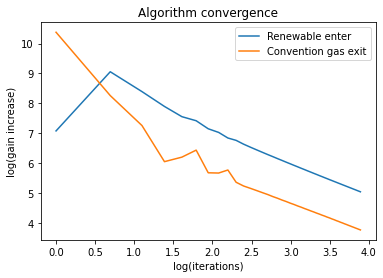

In [20]:
# Algorithm convergence illustration
logIter = np.log(range(1,Niter,1))

plt.figure()
plt.plot(logIter, np.log(save_ob_R[1:]), label = "Renewable enter")
plt.plot(logIter, np.log(save_ob_G[1:]), label = "Convention gas exit")
plt.title("Algorithm convergence")
plt.xlabel('log(iterations)')
plt.ylabel('log(gain increase)')
plt.legend()
plt.show()

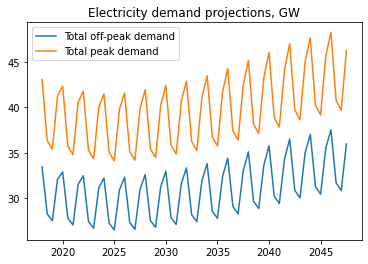

In [21]:
# Electricity demand projections, GW
plt.figure()
plt.plot(2018+T[:60],opdemand[:60],label='Total off-peak demand')
plt.plot(2018+T[:60],pdemand[:60],label='Total peak demand')
plt.title('Electricity demand projections, GW')
plt.legend()
plt.show()

Text(0.5, 0.92, 'Renewable')

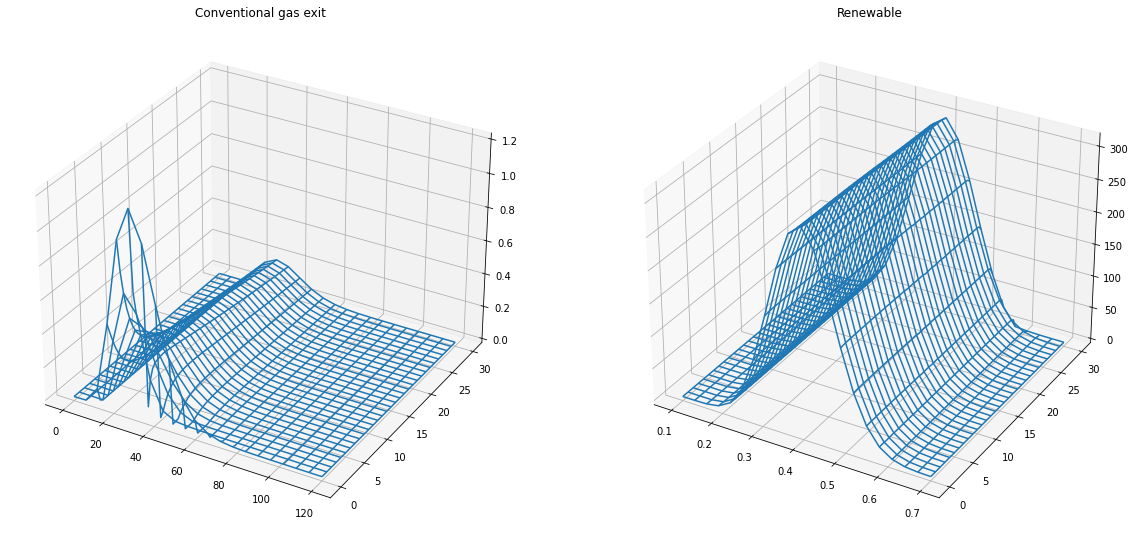

In [22]:
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot

newOm = np.reshape(Omega,(Nt,NC))
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
XX, YY = np.meshgrid(C, T)
ax.plot_wireframe(XX, YY, newOm)
plt.title('Conventional gas exit')

newEta = np.reshape(Eta,(Nt,NS))
XX, YY = np.meshgrid(S, T)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_wireframe(XX, YY, newEta)
plt.title('Renewable')

Text(0.5, 1.0, 'Renewable')

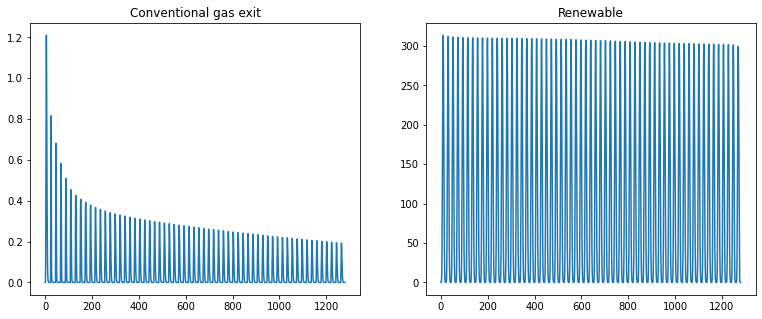

In [23]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.plot(Omega)
plt.title('Conventional gas exit')

plt.subplot(1,2,2)
plt.plot(Eta)
plt.title('Renewable')

Text(0.5, 1.0, 'Renewable')

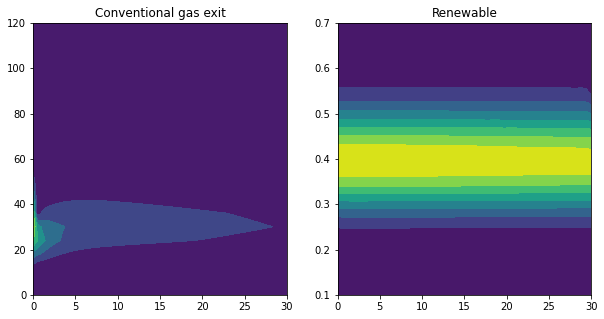

In [24]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
XX, YY = np.meshgrid(C, T)
plt.contourf(YY, XX, newOm)
plt.title('Conventional gas exit')

plt.subplot(1,2,2)
XX, YY = np.meshgrid(S, T)
plt.contourf(YY, XX, newEta)
plt.title('Renewable')

<ipython-input-25-d026e0ca9f83>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('231')
<ipython-input-25-d026e0ca9f83>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('232')
<ipython-input-25-d026e0ca9f83>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('233')
<ipython-input-25-d026e0ca9f83>:25: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot('234')
<ipython-input-25-d026e0ca9f83>:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is

Text(0.5, 1.0, 'Conventional installed capacity')

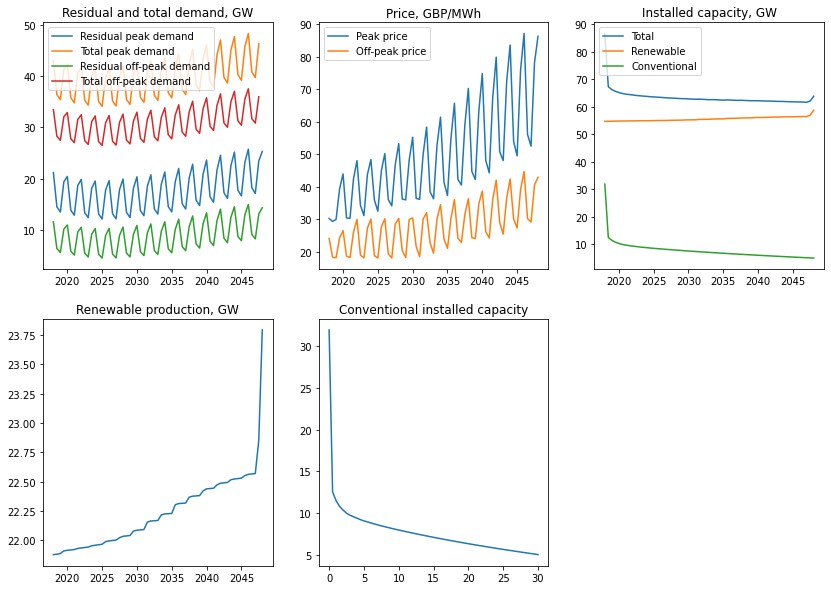

In [25]:
plt.figure(figsize=(14,10))

plt.subplot('231')
plt.plot(2018+T,RRp[:,Niter-1],label='Residual peak demand')
plt.plot(2018+T[:60],pdemand[:60],label='Total peak demand')
plt.plot(2018+T,RRop[:,Niter-1],label='Residual off-peak demand')
plt.plot(2018+T[:60],opdemand[:60],label='Total off-peak demand')
plt.title('Residual and total demand, GW')
plt.legend(loc=2)

plt.subplot('232')
plt.plot(2018+T,prphist[:,Niter-1],label='Peak price')
plt.plot(2018+T,prophist[:,Niter-1],label='Off-peak price')
plt.legend(loc=2)
plt.title('Price, GBP/MWh')

plt.subplot('233')
renhist = np.ones(penhist.shape)*np.sum(BarEta)*dS-penhist
plt.plot(2018+T,renhist[:,Niter-1]+conhist[:,Niter-1],label='Total')
plt.plot(2018+T,renhist[:,Niter-1],label='Renewable')
plt.plot(2018+T,conhist[:,Niter-1],label='Conventional')
plt.legend(loc=2)
plt.title('Installed capacity, GW')

plt.subplot('234')
plt.plot(2018+T,np.sum(BarEta*S)*dS-renpen[:,Niter-1])
plt.title('Renewable production, GW')

#plt.savefig('industry_dynamics_peak_offpeak_baseline.pdf',format='pdf')

plt.subplot('235')
plt.plot(T,conhist[:,-1])
plt.title('Conventional installed capacity')